# Milestone Project 3: BitPredict 📈

Build a time series forecasting model to predict the price of Bitcoin based on its past trends. The reference notebook can be found [here](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb).

The Bitcoin dataset is downloaded from here: https://finance.yahoo.com/quote/BTC-USD/history/

## Get the Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3426 entries, 2014-09-17 to 2024-02-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3426 non-null   float64
 1   High       3426 non-null   float64
 2   Low        3426 non-null   float64
 3   Close      3426 non-null   float64
 4   Adj Close  3426 non-null   float64
 5   Volume     3426 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 187.4 KB


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-29,42030.914063,43305.867188,41818.332031,43288.246094,43288.246094,20668476578
2024-01-30,43300.226563,43838.945313,42711.371094,42952.609375,42952.609375,23842814518
2024-01-31,42946.250000,43717.406250,42298.945313,42582.605469,42582.605469,24673628793
2024-02-01,42569.761719,43243.167969,41879.191406,43075.773438,43075.773438,21423953779
2024-02-02,43077.640625,43398.312500,42939.859375,42998.191406,42998.191406,19835885568


<div class="alert alert-block alert-info">
<b>Note:</b> The seasonality of a time series dataset can be equated to the number of samples present in a year, e.g., it is 365 for the Bitcoin dataset (daily).
</div>

In [5]:
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


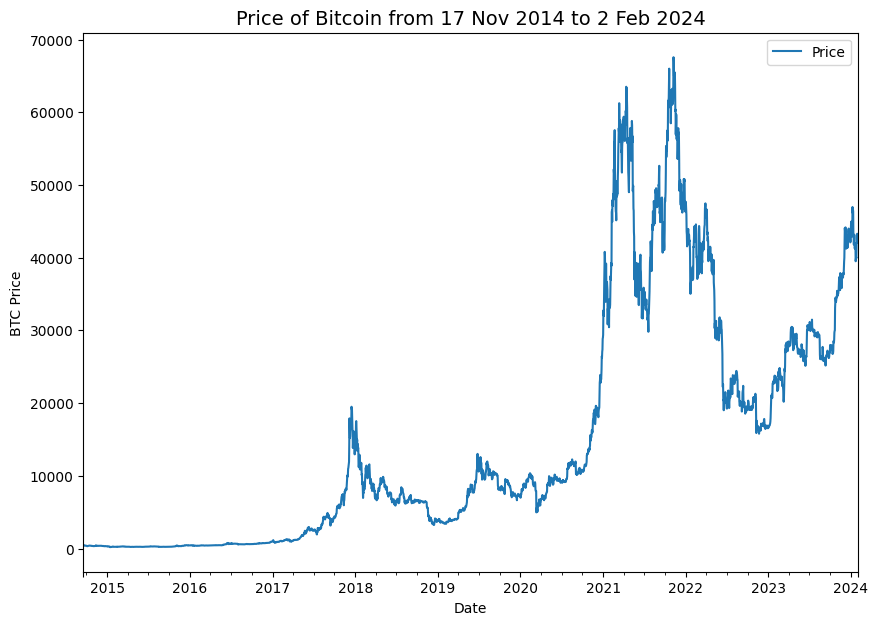

In [6]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 17 Nov 2014 to 2 Feb 2024', fontsize=14)
plt.legend();

## Format the Data (Part 1): Creating the Train and Test Splits

### The Wrong Way

The train and test samples are split randomly from the entire range. Here, the data from the "pseudo-future" leaks into the past data.

In [7]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    timesteps,
    prices,
    test_size=0.2,
    random_state=42    # Randomise the dataset
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2740,), (686,), (2740,), (686,))

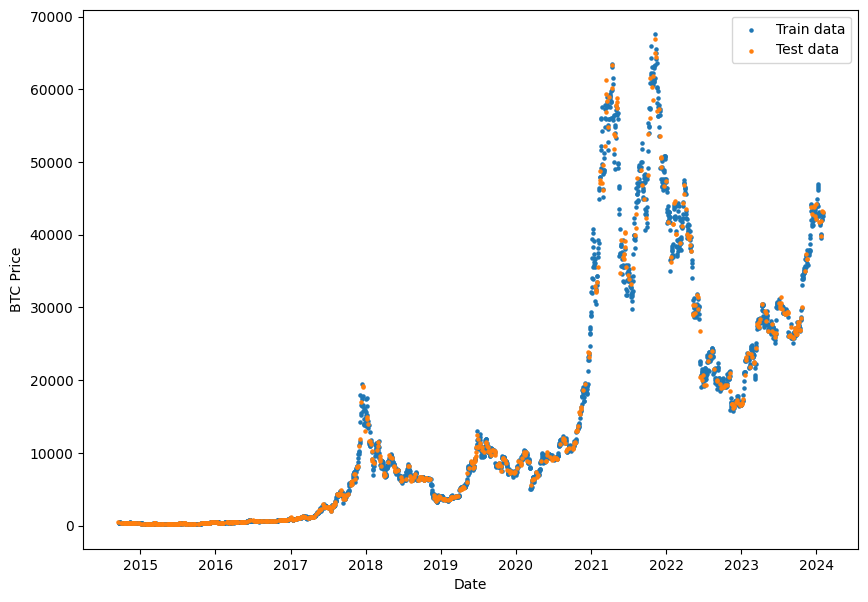

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.legend()
plt.show();

### The Right Way

The train and test samples are split from a cutoff point in the range. Here, the train set is used to predict the "pseudo-future".

In [10]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2740, 686, 2740, 686)

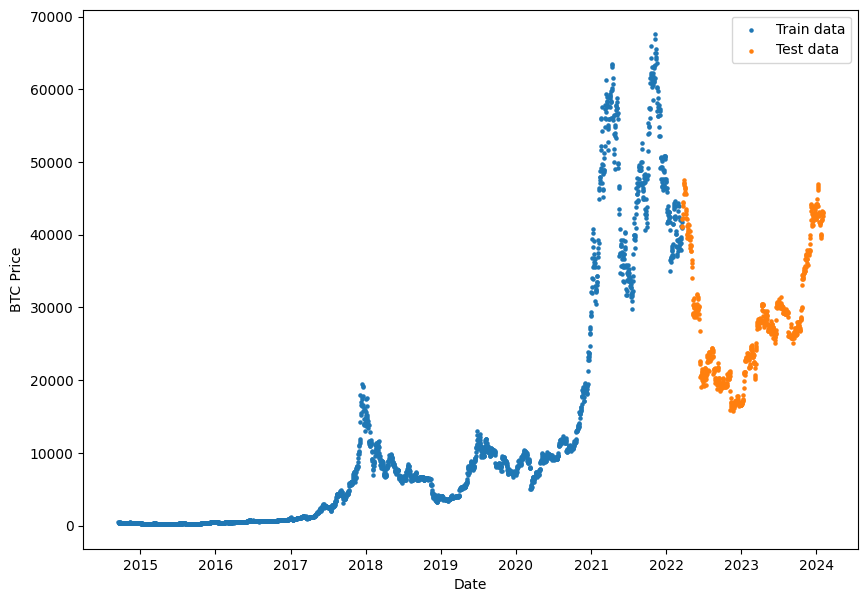

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.legend()
plt.show();

## Create a Plotting Function

In [12]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, ylabel=None):
    """Plots the time series data.

    Parameters
    ----------
    timesteps (array): Array of timestep values.
    values (array): Array of values across time.
    format (string): Style of the plot, default='.'.
    start (int): Starting index of the data, default=0.
    end (int): Ending index of the data, default=None.
    label (string): Label of the plot values, default=None.
    ylabel (string): Label of the y-axis of the plot, default=None.
    """
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel(ylabel=ylabel)
    if label:
        plt.legend()
    plt.grid(True)

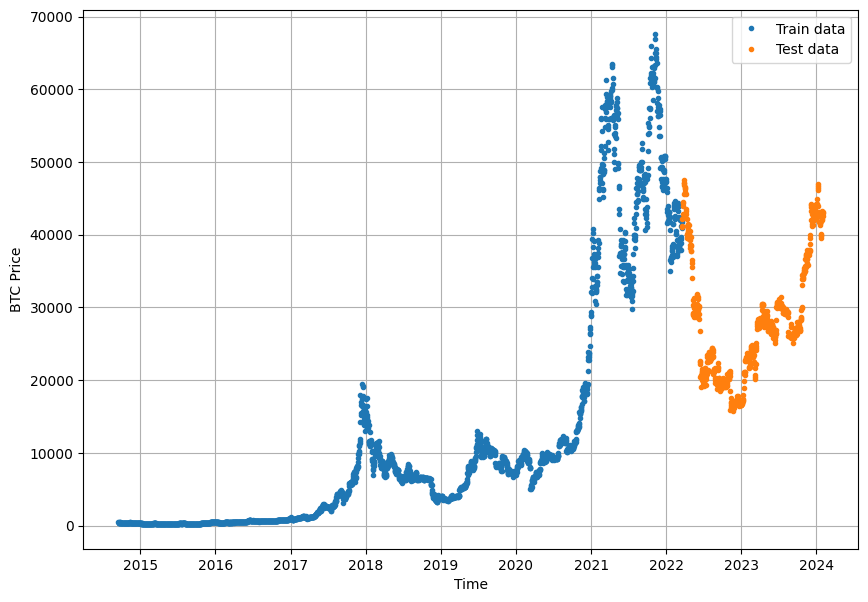

In [13]:
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label='Train data', ylabel='BTC Price')
plot_time_series(X_test, y_test, label='Test data', ylabel='BTC Price')

## The Modelling Experiments

* Model 0: Naive model (baseline)
* Model 1: Dense model (horizon=1, window_size=7)
* Model 2: Same as model 1 (horizon=1, window_size=30)
* Model 3: Same as model 1 (horizon=7, window_size=30)
* Model 4: Conv1D model
* Model 5: LSTM model
* Model 6: Same as model 1 (with multivariate data)
* Model 7: N-BEATS algorithm (https://arxiv.org/abs/1905.10437)
* Model 8: Ensemble (stack multiple models together)
* Model 9: Future prediction model
* Model 10: Same as model 1 (with turkey data)

Some important terms related to these experiments:

* __Horizon__ is the number of timesteps into the future we are going to predict.
* __Window size__ is the number of timesteps we are going to use to predict the horizon.

## Model 0: The Naive Forecast

The formula for the Naive method: $$\hat{y}_{t} = y_{t-1}$$

The prediction ($\hat{y}_{t}$) at the timestep $t$ is equal to the prediction made in the last timestep $t-1$, when the horizon is 1.

In [14]:
y_test[:10], y_test[-10:]

(array([42190.652344, 41247.824219, 41077.996094, 42358.808594,
        42892.957031, 43960.933594, 44348.730469, 44500.828125,
        46820.492188, 47128.003906]),
 array([40077.074219, 39933.808594, 41816.871094, 42120.054688,
        42035.59375 , 43288.246094, 42952.609375, 42582.605469,
        43075.773438, 42998.191406]))

In [15]:
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([42190.652344, 41247.824219, 41077.996094, 42358.808594,
        42892.957031, 43960.933594, 44348.730469, 44500.828125,
        46820.492188, 47128.003906]),
 array([39845.550781, 40077.074219, 39933.808594, 41816.871094,
        42120.054688, 42035.59375 , 43288.246094, 42952.609375,
        42582.605469, 43075.773438]))

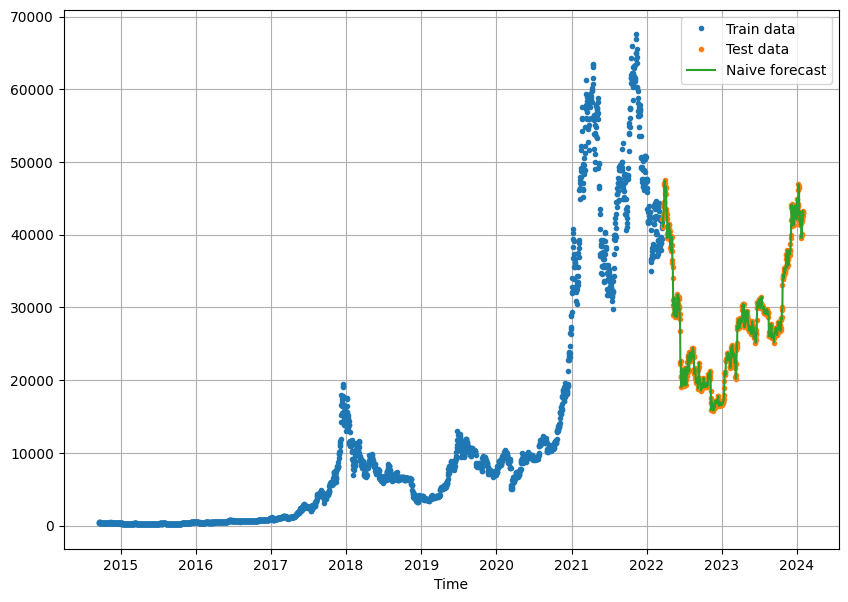

In [16]:
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label='Test data')
plot_time_series(X_test[1:], naive_forecast, format='-', label='Naive forecast')

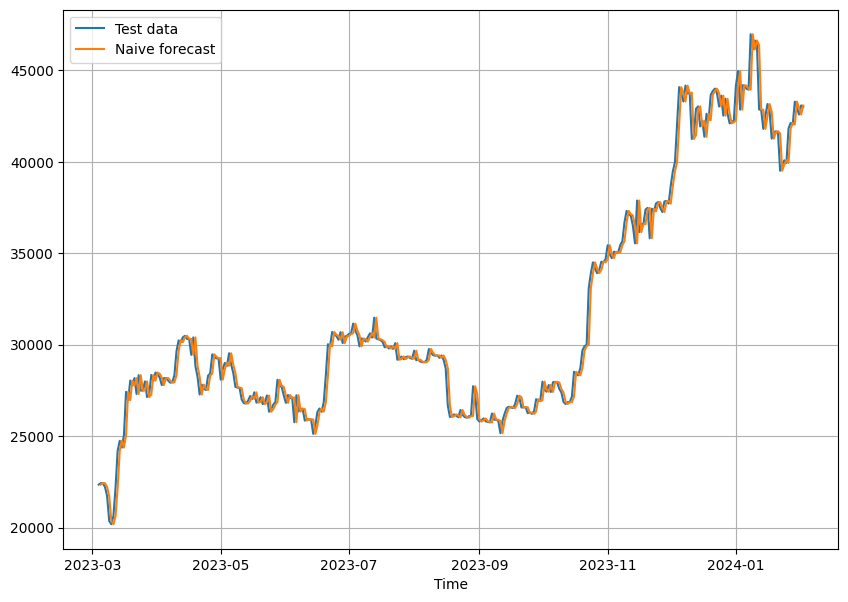

In [17]:
plt.figure(figsize=(10, 7))
plot_time_series(X_test, y_test, start=350, format='-', label='Test data')
plot_time_series(X_test[1:], naive_forecast, start=350, format='-', label='Naive forecast')

<div class="alert alert-block alert-warning">
<b>Note:</b> The time series forecast obtained through the Naive approach is generally hard to beat.
</div>

## Evaluate the Time Series Model

Some time series forecasting evalutaion metrics:

* MAE - Mean absolute error
* MSE - Mean square error
* RMSE - Root mean squared error
* MAPE - Mean absolute percentage error
* MASE - Mean absolute scaled error

In [18]:
import tensorflow as tf

In [19]:
def mean_absolute_scaled_error(y_true, y_pred):
    """Implement MASE when the data is non-seasonal.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find the MAE of the Naive forecast (non-seasonal)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))    # 1-day shift

    return mae / mae_naive_no_season

In [20]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

1.0012669848377538

In [21]:
def evaluate_preds(y_true, y_pred):
    """Take in the model predictions and truth values and returns the evaluation metrics.
    """
    # Make sure that the data is in `float32`
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evalution metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse.numpy(),
        'mape': mape.numpy(),
        'mase': mase.numpy()
    }

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 505.39673,
 'mse': 601674.44,
 'rmse': 775.67676,
 'mape': 1.823844,
 'mase': 1.0012671}

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=27845.739610925655>

In [24]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=15787.28418>,
 <tf.Tensor: shape=(), dtype=float64, numpy=47465.730469>)

## Format the Data (Part-2): Windowing the Dataset

This converts the time series problem into a supervised learning problem.

```
Windowing for 1 week:

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
f'{list(prices[:7])} -> {prices[7]}'

'[457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] -> 423.204987'

In [26]:
# Setup the global variables for horizon and window size
HORIZON = 1
WINDOW_SIZE = 7

In [27]:
def get_labelled_windows(x, horizon=HORIZON):
    """Creates labels for the windowed dataset.

    Example: If horizon=1
    input=[0, 1, 2, 3, 4, 5, 6, 7] -> output=([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [28]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [29]:
f'Window: {tf.squeeze(test_window)} -> Label: {tf.squeeze(test_label)}'

'Window: [0 1 2 3 4 5 6] -> Label: 7'

For more information on indexing: https://numpy.org/doc/stable/user/basics.indexing.html

1. Create a window step of specific window size (e.g., [0, 1, 2, 3, 4, 5, 6]).
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
   ```
   [[0, 1, 2, 3, 4, 5, 6],
   [1, 2, 3, 4, 5, 6, 7],
   [1, 2, 3, 4, 5, 6, 8]]
   ```
3. Use the 2D array to index on a target series (e.g., the historical price of Bitcoin).
4. Use  the `get_labelled_windows()` function to turn the window steps into windows with specified horizon.

In [30]:
import numpy as np

In [31]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """Turns a 1D array into a 2D array of sequentially
    labelled windows of window_size with horizon size labels.
    """
    # Create a window step of the specified size
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # Create the 2D array of multiple window steps (minus 1 for 0-indexing)
    window_indexes = window_step + np.expand_dims(np.arange(
        len(x) - (window_size + horizon - 1)
    ), axis=0).T

    # Index on the target array with the 2D array
    windowed_array = x[window_indexes]

    # Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [32]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3419, 3419)

In [33]:
for i in range(3):
    print(f'Window: {list(full_windows[i])} -> Label: {full_labels[i]}')

Window: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] -> Label: [423.204987]
Window: [424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985, 423.204987] -> Label: [411.574005]
Window: [394.79599, 408.903992, 398.821014, 402.152008, 435.790985, 423.204987, 411.574005] -> Label: [404.424988]


TensorFlow method to perform the same operation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turn Windows into the Train and Test Sets

In [34]:
def make_train_test_split(windows, labels, test_split=0.2):
    """Splits matching pairs of windows and labels into train and test sets.
    """
    split_size = int(len(windows) * (1 - test_split))    # Default: 80% train, 20% test
    
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [35]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2735, 684, 2735, 684)

In [36]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [37]:
test_windows[:5], test_labels[:5]

(array([[39666.753906, 39338.785156, 41143.929688, 40951.378906,
         41801.15625 , 42190.652344, 41247.824219],
        [39338.785156, 41143.929688, 40951.378906, 41801.15625 ,
         42190.652344, 41247.824219, 41077.996094],
        [41143.929688, 40951.378906, 41801.15625 , 42190.652344,
         41247.824219, 41077.996094, 42358.808594],
        [40951.378906, 41801.15625 , 42190.652344, 41247.824219,
         41077.996094, 42358.808594, 42892.957031],
        [41801.15625 , 42190.652344, 41247.824219, 41077.996094,
         42358.808594, 42892.957031, 43960.933594]]),
 array([[41077.996094],
        [42358.808594],
        [42892.957031],
        [43960.933594],
        [44348.730469]]))

## Create the Modelling Checkpoint

Since the models are trained for a larger number of epochs, it's best to save the model's best performance.

In [38]:
import os

def create_model_checkpoint(model_name, save_path='mp3_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        monitor='val_loss',
        save_best_only=True
    )

## Model 1: Dense Model (window = 7, horizon = 1)

In [39]:
import logging, sys

logging.disable(sys.maxsize)

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')

model_1.compile(
    loss='mae',
    optimizer = tf.keras.optimizers.legacy.Adam(),
    metrics=['mae']
)

model_1.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_1.name)]
)

Epoch 1/100
22/22 [==============================] - 1s 33ms/step - loss: 3219.5408 - mae: 3219.5408 - val_loss: 911.7406 - val_mae: 911.7406
Epoch 2/100
22/22 [==============================] - 1s 28ms/step - loss: 660.2479 - mae: 660.2479 - val_loss: 783.5995 - val_mae: 783.5995
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 486.9911 - mae: 486.9911 - val_loss: 799.5785 - val_mae: 799.5785
Epoch 4/100
22/22 [==============================] - 0s 21ms/step - loss: 449.8387 - mae: 449.8387 - val_loss: 684.0078 - val_mae: 684.0078
Epoch 5/100
22/22 [==============================] - 0s 21ms/step - loss: 431.5840 - mae: 431.5840 - val_loss: 620.6546 - val_mae: 620.6546
Epoch 6/100
22/22 [==============================] - 0s 1ms/step - loss: 410.3106 - mae: 410.3106 - val_loss: 683.1649 - val_mae: 683.1649
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 396.7924 - mae: 396.7924 - val_loss: 671.9431 - val_mae: 671.9431
Epoch 8/100
22/22 [==

In [41]:
model_1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 548us/step - loss: 660.4852 - mae: 660.4852


[660.4852294921875, 660.4852294921875]

In [42]:
# Load in the best performing model and evaluate it on test data
model_1 = tf.keras.models.load_model('mp3_experiments/model_1_dense/')
model_1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 574us/step - loss: 507.1899 - mae: 507.1899


[507.18988037109375, 507.18988037109375]

## Make Forecasts with a Model (on the Test Dataset)

To make pseudo-forecasts, the following steps are followed:

1. Take in a trained model.
2. Take in some input data.
3. Make predictions with the input data.

In [43]:
def make_preds(model, input_data):
    """Uses model to make predictions on the input data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [44]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

22/22 [==============================] - 0s 496us/step


(684,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([41271.71 , 41167.992, 42161.945, 42834.527, 43888.133, 44352.688,
        44477.883, 46679.44 , 47188.902, 47501.05 ], dtype=float32)>)

In [45]:
test_labels[:10]

array([[41077.996094],
       [42358.808594],
       [42892.957031],
       [43960.933594],
       [44348.730469],
       [44500.828125],
       [46820.492188],
       [47128.003906],
       [47465.730469],
       [47062.664063]])

In [46]:
model_1_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=tf.squeeze(model_1_preds)
)
model_1_results

{'mae': 507.1901,
 'mse': 603887.0,
 'rmse': 777.1017,
 'mape': 1.8372449,
 'mase': 1.0038447}

In [47]:
naive_results

{'mae': 505.39673,
 'mse': 601674.44,
 'rmse': 775.67676,
 'mape': 1.823844,
 'mase': 1.0012671}

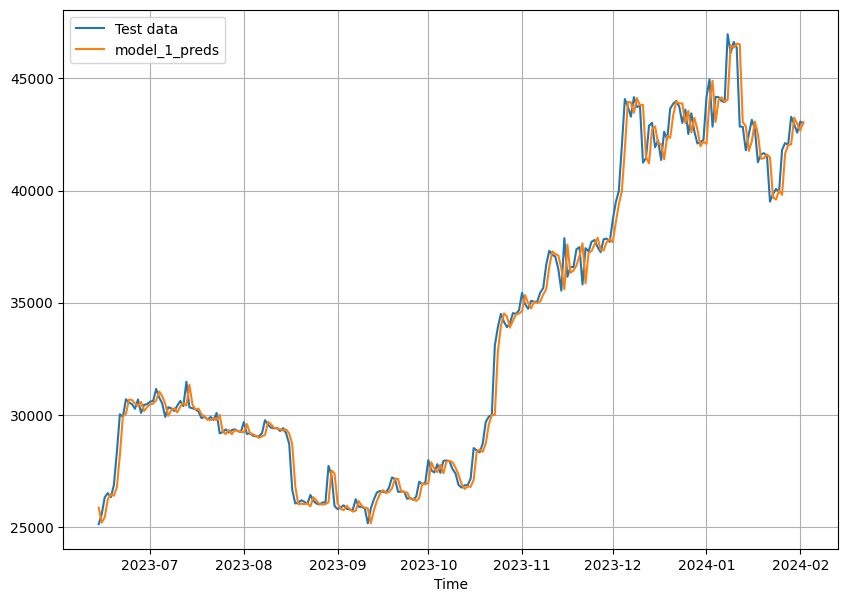

In [48]:
# Plot the model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    format='-',
    label='Test data'
)
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_1_preds,
    start=offset,
    format='-',
    label='model_1_preds'
)

## Model 2: Dense Model (window = 30, horizon = 1)

In [49]:
HORIZON = 1
WINDOW_SIZE = 30

In [50]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3396, 3396)

In [51]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2716, 680, 2716, 680)

In [52]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

model_2.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['mae']
)

model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_2.name)]
)

In [53]:
model_2.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 567us/step - loss: 531.6683 - mae: 531.6683


[531.6682739257812, 531.6682739257812]

In [54]:
model_2 = tf.keras.models.load_model('mp3_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 574us/step - loss: 531.6683 - mae: 531.6683


[531.6682739257812, 531.6682739257812]

In [55]:
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10]

22/22 [==============================] - 0s 514us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([43475.625, 45202.43 , 44443.41 , 46936.91 , 47045.527, 47043.61 ,
       47025.438, 45309.684, 46043.44 , 46134.168], dtype=float32)>

In [56]:
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_2_preds
)
model_2_results

{'mae': 531.6684,
 'mse': 633354.5,
 'rmse': 795.83575,
 'mape': 1.92951,
 'mase': 1.0561403}

In [57]:
model_1_results

{'mae': 507.1901,
 'mse': 603887.0,
 'rmse': 777.1017,
 'mape': 1.8372449,
 'mase': 1.0038447}

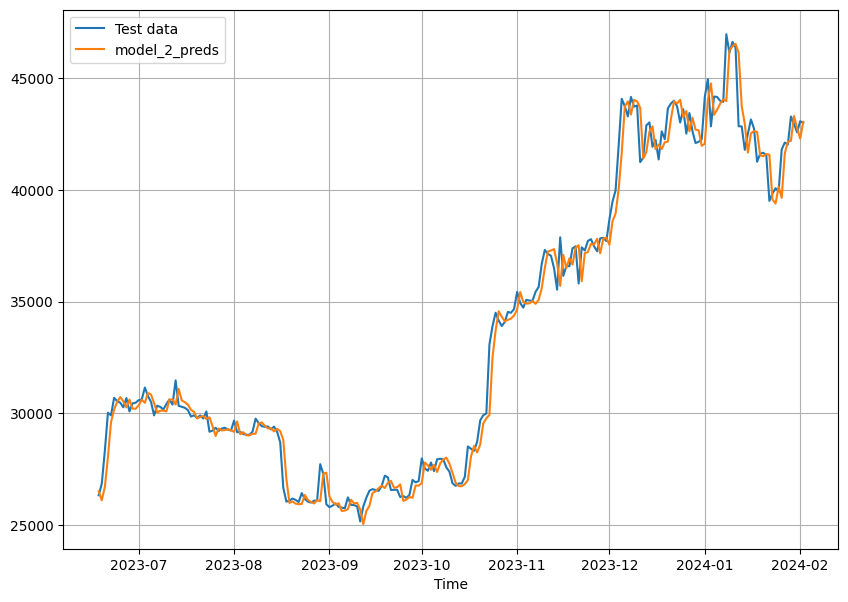

In [58]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    format='-',
    label='Test data'
)
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_2_preds,
    start=offset,
    format='-',
    label='model_2_preds'
)

## Model 3: Dense Model (window = 30, horizon = 7)

In [59]:
HORIZON = 7
WINDOW_SIZE = 30

In [60]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3390, 3390)

In [61]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2712, 678, 2712, 678)

In [62]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

model_3.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['mae']
)

model_3.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_3.name)]
)

In [63]:
model_3.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 555us/step - loss: 1167.6669 - mae: 1167.6669


[1167.6668701171875, 1167.6668701171875]

In [64]:
model_3 = tf.keras.models.load_model('mp3_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 583us/step - loss: 1082.6880 - mae: 1082.6880


[1082.68798828125, 1082.68798828125]

In [65]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

22/22 [==============================] - 0s 534us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[41347.78 , 41944.1  , 41671.13 , 42679.715, 41603.582, 40926.215,
        41007.19 ],
       [41703.625, 40708.215, 41818.613, 43236.88 , 41280.445, 41209.62 ,
        42394.766],
       [41997.953, 41470.65 , 41659.254, 42689.812, 42619.125, 41558.4  ,
        42902.004],
       [42661.22 , 42510.035, 43185.367, 42581.484, 42986.84 , 42851.23 ,
        42889.387],
       [43804.695, 44021.164, 44091.098, 42656.902, 42362.562, 43593.54 ,
        43181.203]], dtype=float32)>

## Make the Evaluation Function Work with Larger Horizons

In [66]:
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)

In [67]:
model_3_results['mae'].shape, model_3_results['mae'].ndim

((678,), 1)

In [68]:
def evaluate_preds(y_true, y_pred):
    """Take in the model predictions and truth values and returns the evaluation metrics.
    """
    # Make sure that the data is in `float32`
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evalution metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse.numpy(),
        'mape': mape.numpy(),
        'mase': mase.numpy()
    }

In [69]:
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)
model_3_results

{'mae': 1082.688,
 'mse': 2699470.0,
 'rmse': 1251.2799,
 'mape': 3.9796574,
 'mase': 2.1475525}

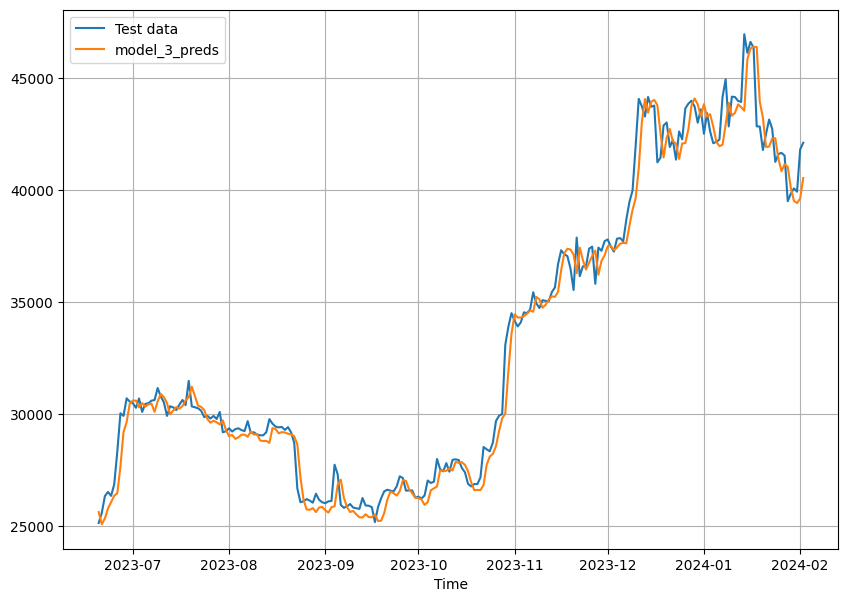

In [70]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    format='-',
    label='Test data'
)
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=tf.reduce_mean(model_3_preds, axis=1),
    start=offset,
    format='-',
    label='model_3_preds'
)

## Compare the Performance of the Dense Models

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It measures the relationship between a variable's current value and its past values.

For more information: https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

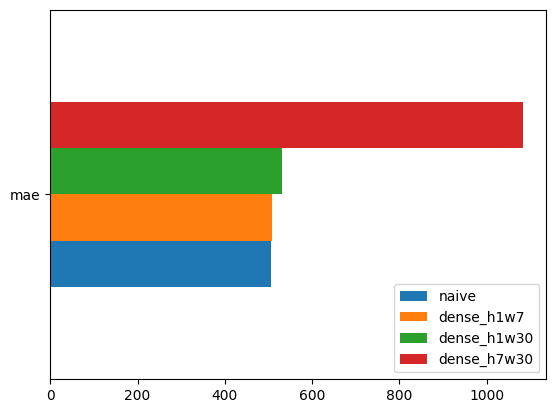

In [71]:
pd.DataFrame({
    'naive': naive_results['mae'],
    'dense_h1w7': model_1_results['mae'],
    'dense_h1w30': model_2_results['mae'],
    'dense_h7w30': model_3_results['mae']
}, index=['mae']).plot(kind='barh');

## Model 4: The Conv1D Model

For more information on the Lambda layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

In [72]:
HORIZON = 1
WINDOW_SIZE = 7

In [73]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3419, 3419)

In [74]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2735, 684, 2735, 684)

In [75]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1d')

model_4.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam()
)

model_4.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)]
)

In [76]:
model_4.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 744us/step - loss: 909.6509


909.6509399414062

In [77]:
model_4 = tf.keras.models.load_model('mp3_experiments/model_4_conv1d/')
model_4.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 596us/step - loss: 509.8073


509.8072814941406

In [78]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

22/22 [==============================] - 0s 548us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41519.707, 41118.24 , 42088.777, 42820.992, 43771.297, 44328.332,
       44577.54 , 46465.96 , 47221.66 , 47532.17 ], dtype=float32)>

In [80]:
model_4_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_4_preds
)
model_4_results

{'mae': 509.80728,
 'mse': 607330.9,
 'rmse': 779.3144,
 'mape': 1.8488792,
 'mase': 1.0090247}

## Model 5: The LSTM Model

In [82]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_lstm')

model_5.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam()
)

model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

In [83]:
model_5.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 528.1088


528.1087646484375

In [84]:
model_5 = tf.keras.models.load_model('mp3_experiments/model_5_lstm/')
model_5.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 895us/step - loss: 528.1088


528.1087646484375

In [85]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

22/22 [==============================] - 0s 861us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41627.45 , 41253.758, 41940.152, 42637.383, 43609.6  , 44236.664,
       44585.805, 46256.562, 47060.312, 47545.246], dtype=float32)>

In [87]:
model_5_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_5_preds
)
model_5_results

{'mae': 528.1086,
 'mse': 639573.75,
 'rmse': 799.7335,
 'mape': 1.9180255,
 'mase': 1.0452472}

## Make a Multivariate Time Series Dataset

Encoding the Bitcoin halving periods: https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [89]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [91]:
# Add the Bitcoin halving events to the dataset

block_reward_1 = 50      # 3-Jan-2009 - does not exist in the dataset
block_reward_2 = 25      # 28-Nov-2012
block_reward_3 = 12.5    # 9-Jul-2016
block_reward_4 = 6.25    # 18-May-2020

# Get the Bitcoin reward dates
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

In [92]:
# Create date ranges for the block rewards
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days

(661, 2070)

In [94]:
# Add a block reward column to the dataframe
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add the block reward data to the dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [95]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2024-01-29,43288.246094,6.25
2024-01-30,42952.609375,6.25
2024-01-31,42582.605469,6.25
2024-02-01,43075.773438,6.25
2024-02-02,42998.191406,6.25


In [96]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


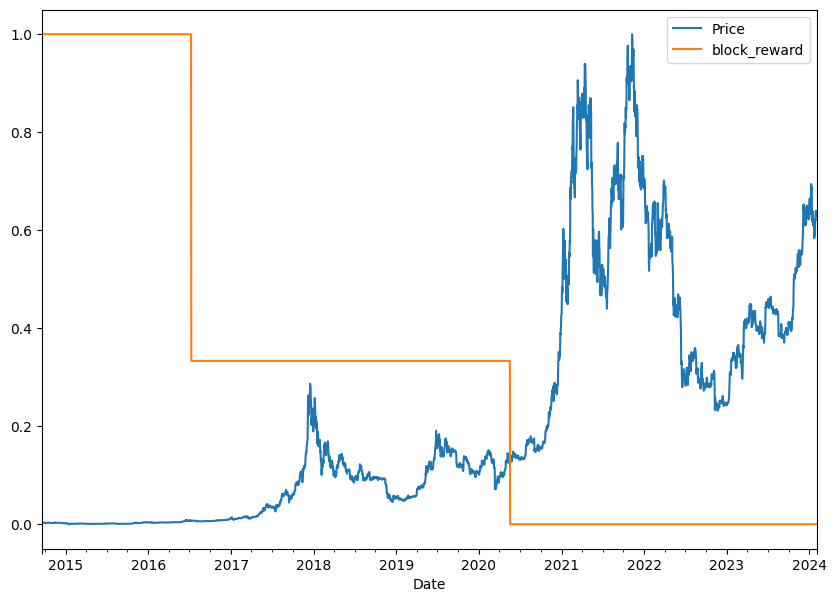

In [100]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale

scaled_prices_block_df = pd.DataFrame(
    minmax_scale(
        bitcoin_prices_block[['Price', 'block_reward']]
    ),
    columns=bitcoin_prices_block.columns,
    index=bitcoin_prices_block.index)
scaled_prices_block_df.plot(figsize=(10, 7));

## Make a Windowed Dataset for the Multivariate Data

For more information: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [101]:
HORIZON = 1
WINDOW_SIZE = 7

In [102]:
# Make a copy of the multivariate dataset
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [104]:
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [105]:
y.head()

Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: Price, dtype: float32

In [106]:
split_size = int(0.8 * len(X))

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2735, 684, 2735, 684)

## Model 6: Dense Model with Multivariate Data

In [125]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

model_6.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam()
)

model_6.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(model_name=model_6.name)]
)

In [126]:
model_6.evaluate(X_test, y_test)

22/22 [==============================] - 0s 627us/step - loss: 765.7513


765.7513427734375

In [127]:
model_6 = tf.keras.models.load_model('mp3_experiments/model_6_dense_multivariate/')
model_6.evaluate(X_test, y_test)

22/22 [==============================] - 0s 535us/step - loss: 505.0763


505.0762634277344

In [128]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

22/22 [==============================] - 0s 563us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41302.438, 41182.734, 42238.81 , 42829.27 , 43908.895, 44400.78 ,
       44512.402, 46700.066, 47162.332, 47493.61 ], dtype=float32)>

In [129]:
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': 505.07626,
 'mse': 601515.44,
 'rmse': 775.5743,
 'mape': 1.827839,
 'mase': 0.999661}

In [114]:
model_1_results

{'mae': 507.1901,
 'mse': 603887.0,
 'rmse': 777.1017,
 'mape': 1.8372449,
 'mase': 1.0038447}

## Model 6.1: Hybrid-Input Multivariate Dense Model

In [148]:
X_train.drop('block_reward', axis=1).to_numpy().shape

(2735, 7)

In [149]:
X_train['block_reward'].to_numpy().shape

(2735,)

In [158]:
tf.random.set_seed(42)

price_inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Dense(128, activation='relu')(price_inputs)
price_model = tf.keras.Model(inputs=price_inputs, outputs=x)

block_inputs = layers.Input(shape=(1,))
y = layers.Dense(128, activation='relu')(block_inputs)
block_model = tf.keras.Model(inputs=block_inputs, outputs=y)

hybrid_embeddings = layers.Concatenate()([
    price_model.output,
    block_model.output
])

output_layer = layers.Dense(HORIZON)(hybrid_embeddings)

model_6_1 = tf.keras.Model(
    inputs=[
        price_model.input,
        block_model.input
    ],
    outputs=output_layer,
    name='model_6_1_hybrid_multivariate'
)

model_6_1.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam()
)

model_6_1.fit(
    x=[
        X_train.drop('block_reward', axis=1),
        X_train['block_reward']
    ],
    y=y_train,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=((
        X_test.drop('block_reward', axis=1),
        X_test['block_reward']
    ), y_test),
    callbacks=[create_model_checkpoint(model_name=model_6_1.name)]
)

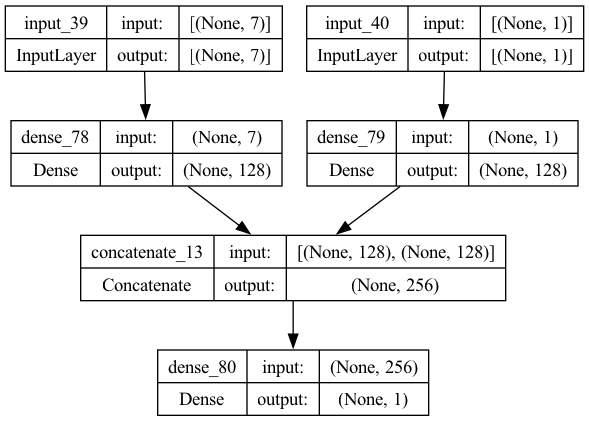

In [160]:
tf.keras.utils.plot_model(model=model_6_1, to_file=f'bitpredict_{model_6_1.name}.png', show_shapes=True)

In [161]:
model_6_1.evaluate((
    X_test.drop('block_reward', axis=1),
    X_test['block_reward']
), y_test)

22/22 [==============================] - 0s 586us/step - loss: 775.6354


775.6354370117188

In [162]:
model_6_1 = tf.keras.models.load_model('mp3_experiments/model_6_1_hybrid_multivariate/')
model_6_1.evaluate((
    X_test.drop('block_reward', axis=1),
    X_test['block_reward']
), y_test)

22/22 [==============================] - 0s 633us/step - loss: 509.4496


509.4496154785156

In [164]:
model_6_1_preds = tf.squeeze(model_6_1.predict((
    X_test.drop('block_reward', axis=1),
    X_test['block_reward']
)))
model_6_1_preds[:10]

22/22 [==============================] - 0s 863us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41494.984, 41009.625, 42126.78 , 42758.996, 43730.82 , 44307.176,
       44565.64 , 46454.1  , 47136.734, 47459.97 ], dtype=float32)>

In [165]:
model_6_1_results = evaluate_preds(y_true=y_test, y_pred=model_6_1_preds)
model_6_1_results

{'mae': 509.44946,
 'mse': 605971.44,
 'rmse': 778.44165,
 'mape': 1.8435985,
 'mase': 1.0083166}

In [166]:
model_6_results

{'mae': 505.07626,
 'mse': 601515.44,
 'rmse': 775.5743,
 'mape': 1.827839,
 'mase': 0.999661}

## Model 7: N-BEATS Algorithm-Based Model

The research paper can be found here: https://arxiv.org/abs/1905.10437

### Building and Testing the N-BEATS Block Layer

For more information on subclassing: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [178]:
# Create the NBeatsBlock custom layer
tf.random.set_seed(42)

class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, input_size: int, theta_size: int, horizon: int, n_neurons: int, n_layers: int, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # The block contains a stack of 4 dense layers with ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]

        # The output of the block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta_layer')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)

        # Get the outputs for the backcast and forecast from the theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

        return backcast, forecast

In [179]:
# Testing the NBeatsBlock custom layer
dummy_nbeats_block_layer = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE+HORIZON,
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4
)

In [180]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [181]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
backcast, forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[-0.18518803, -0.14845105,  0.01364151, -0.3015566 , -0.27205124,
         -0.49080482, -0.42938864]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.1473355], dtype=float32)>)

### Preparing the Data for the N-BEATS Algorithm using tf.data

In [183]:
HORIZON = 1
WINDOW_SIZE = 7

In [184]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [185]:
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [186]:
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

split_size = int(0.8 * len(X))

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2735, 684, 2735, 684)

In [191]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine the features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch the datasets
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Setting-up the Hyperparameters for the N-BEATS Algorithm Model

These hyperparameters can be found in the Table 18 of the research paper: https://arxiv.org/abs/1905.10437

In [192]:
# Values from the N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting Ready for the Residual Connections

Before crafting the N-BEATS model, two layers (subtract and add) are required to establish the residual connections.

The N-BEATS algorithm uses a double residual stacking system to train their model's architecture.

For more information:

* [Wiki: Residual Neural Network](https://en.wikipedia.org/wiki/Residual_neural_network)
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [193]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

In [195]:
# Subtract the tensors
subtracted = layers.subtract([tensor_1, tensor_2])

# Add the tensors
added = layers.add([tensor_1, tensor_2])

subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, Compiling, and Fitting the N-BEATS Model

1. Setup an instance of the N-BEATS block layer using the `NBeatsBlock` class.
2. Create an input layer for the N-BEATS stack.
3. Make the initial backcast and forecast for the  model with layer in (1).
4. Use a `for` loop to create stacks of the block layers.
5. Use the `NBeatsBlock` class within the `for` loop in (4) to create a block.
6. Create the double residual stacking using `subtract` and `add` layers.
7. Put the model inputs and outputs together using `tf.keras.Model()`.
8. Compile the model with MAE loss and the Adam optimizer.
9. Fit the N-BEATS model for 5000 epochs with the following callbacks:
   * `EarlyStopping` - To stop fitting once the model stops improving while training.
   * `ReduceLROnPlateau` - To lower the learning rate once the model stops improving while training.

For more information on LR: https://www.geeksforgeeks.org/learning-rate-decay

In [197]:
%%time

tf.random.set_seed(42)

# 1. Setup the instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size=INPUT_SIZE,
    theta_size=THETA_SIZE,
    horizon=HORIZON,
    n_neurons=N_NEURONS,
    n_layers=N_LAYERS,
    name='initial_block'
)

# 2. Create the input stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name='stack_input')

# 3. Create the initial backcast and forecast inputs
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)):    # Inital stack in (1)
    # 5. Use the NBeatsBlock to calculate backcast and forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f'NBeatsBlock_{i}'
    )(residuals)

    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
    forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='model_7_NBEATS')

# 8. Compile the model
model_7.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam()
)

# 9. Fit the model
model_7.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=test_dataset,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=200,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=100,
            verbose=1
        )
    ]
)


Epoch 302: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1093: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1193: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 5h 19min 4s, sys: 12min 53s, total: 5h 31min 58s
Wall time: 55min 3s


In [198]:
# Evaluate the N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 200ms/step - loss: 503.6526


503.652587890625

In [202]:
# Make predictions with the N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 0s 250ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41345.473, 41075.445, 42206.66 , 42834.707, 43902.754, 44397.305,
       44558.957, 46708.223, 47203.855, 47538.406], dtype=float32)>

In [200]:
# Evaluate the N-BEATS model's predictions
model_7_results = evaluate_preds(y_true=y_test, y_pred=model_7_preds)
model_7_results

{'mae': 503.6526,
 'mse': 598754.6,
 'rmse': 773.79236,
 'mape': 1.8211318,
 'mase': 0.9968433}

In [201]:
model_1_results

{'mae': 507.1901,
 'mse': 603887.0,
 'rmse': 777.1017,
 'mape': 1.8372449,
 'mase': 1.0038447}

### Plotting the Architecture of the N-BEATS Model

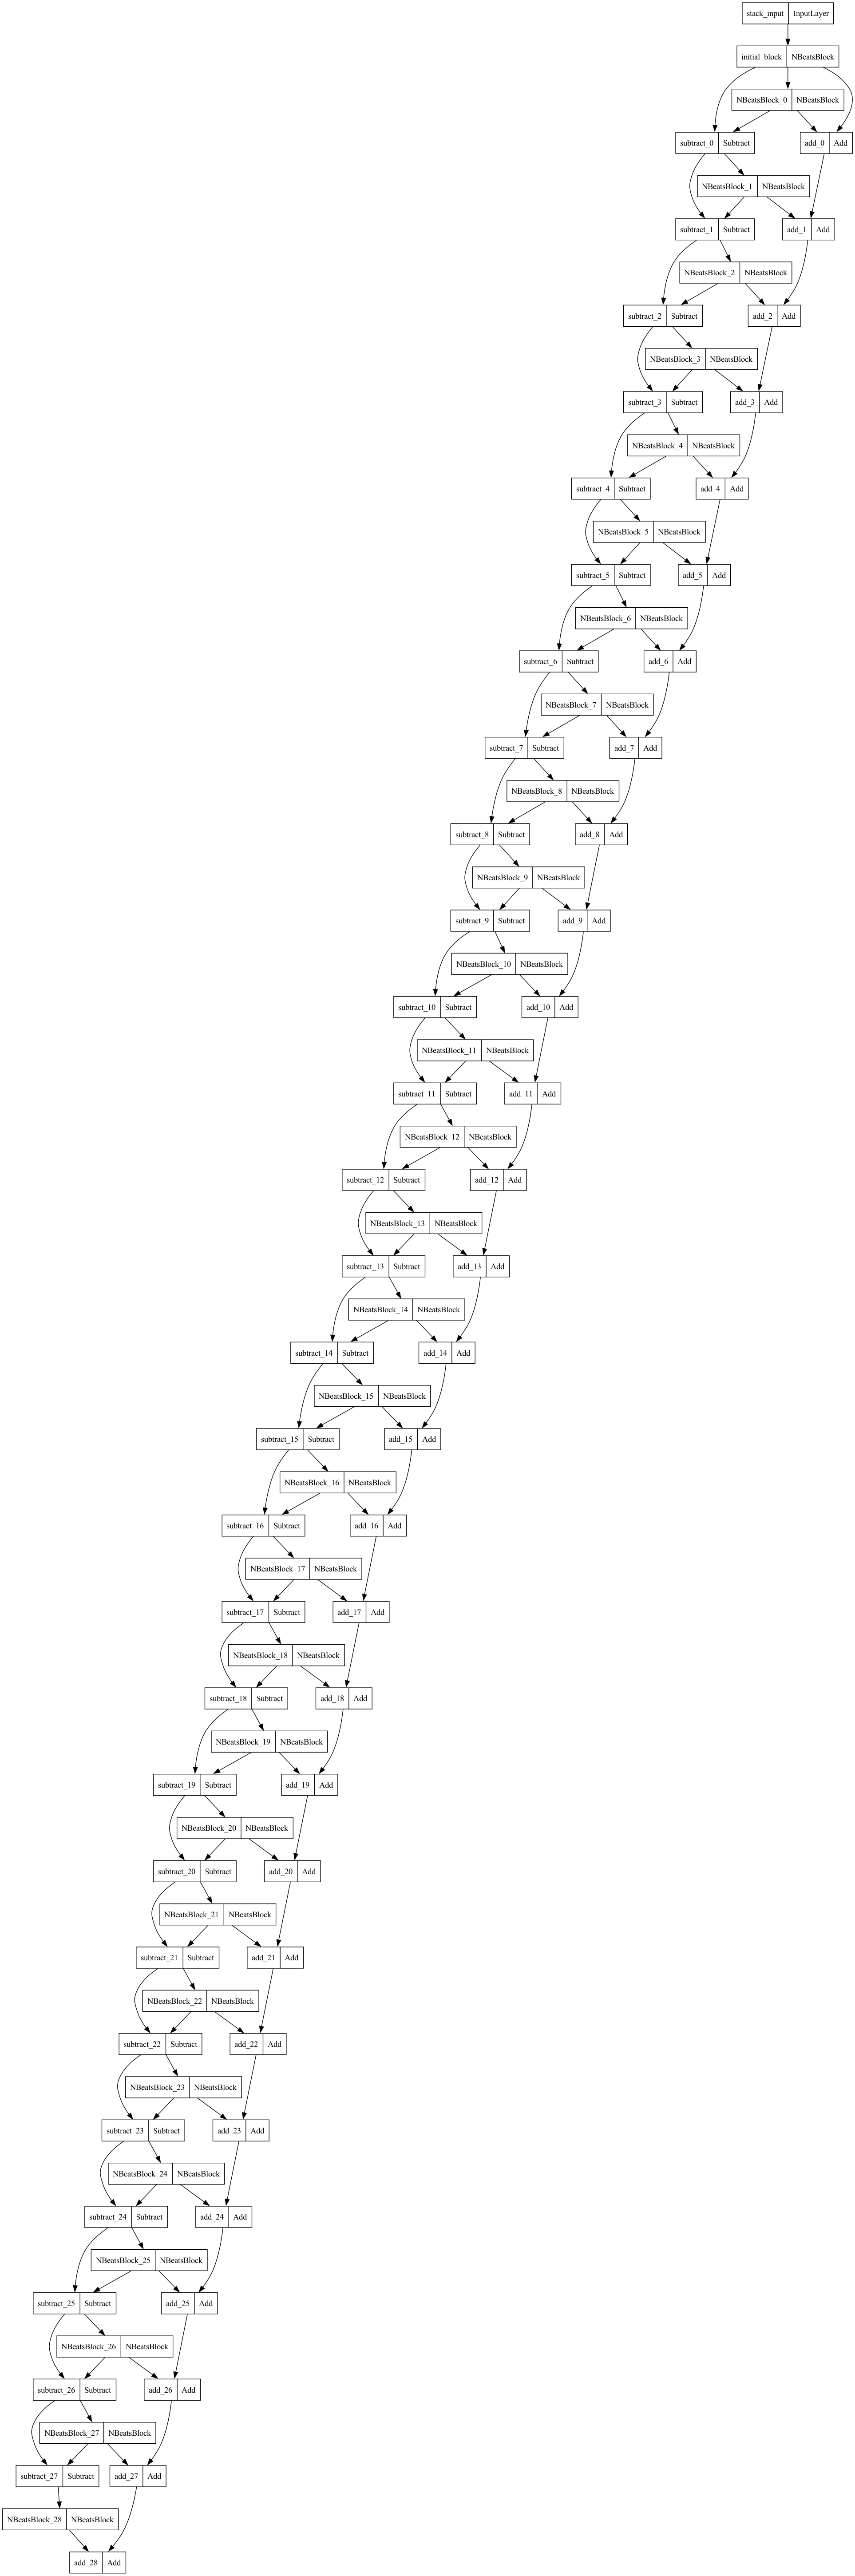

In [204]:
tf.keras.utils.plot_model(model_7, to_file='bitpredict_model_7_nbeats.png')

## Model 8: The Ensemble Model

In machine learning, an ensemble combines multiple different models to predict a common goal.

For more information: https://en.wikipedia.org/wiki/Ensemble_learning

In [205]:
HORIZON = 1
WINDOW_SIZE = 7

###  Constructing and Fitting an Ensemble of Models (Different Loss Functions)

In [218]:
def get_ensemble_models(
    horizon=HORIZON,
    train_data=train_dataset,
    test_data=test_dataset,
    num_iter=10,
    num_epochs=1000,
    loss_fns=['mae', 'mse', 'mape']
):
    """Returns a list of `num_iter` models each trained on MAE, MSE & MAPE losses.
    """
    ensemble_models = []

    for i in range(num_iter):
        for loss_fn in loss_fns:
            print(f'[model_8-{i}] Optimising by reducing: {loss_fn} for {num_epochs} epochs')

            # Construct a simple model (similar to model_1)
            model = tf.keras.Sequential([
                # Initialise dense layers with normal distribution for estimating the predictions
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(HORIZON)
            ])

            # Compile the current model
            model.compile(
                loss=loss_fn,
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse']
            )

            # Fit the current model
            model.fit(
                train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=200,
                        restore_best_weights=True
                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                        monitor='val_loss',
                        patience=100,
                        verbose=1
                    )
                ]
            )

            # Append the fitted model to the list of ensemble models
            ensemble_models.append(model)

            # Add a newline
            print()
        
        print('----------\n')

    return ensemble_models

In [219]:
%%time

ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)
ensemble_models

[model_8-0] Optimising by reducing: mae for 1000 epochs

Epoch 404: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

[model_8-0] Optimising by reducing: mse for 1000 epochs

Epoch 759: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 859: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

[model_8-0] Optimising by reducing: mape for 1000 epochs

Epoch 216: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 660: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 760: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

----------

[model_8-1] Optimising by reducing: mae for 1000 epochs

Epoch 569: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

[model_8-1] Optimising by reducing: mse for 1000 epochs

Epoch 291: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 391: ReduceLROnPlateau reducing learning rate to 1.00000

In [220]:
len(ensemble_models)

15

### Make Predictions with the Ensemble Model

For more information on combining point predictions: https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [221]:
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        ensemble_preds.append(model.predict(data))
    
    return tf.constant(tf.squeeze(ensemble_preds))

In [222]:
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 40ms/step
CPU times: user 577 ms, sys: 140 ms, total: 717 ms
Wall time: 946 ms


<tf.Tensor: shape=(15, 684), dtype=float32, numpy=
array([[41021.42 , 41062.816, 42327.44 , ..., 42854.387, 42621.68 ,
        43127.11 ],
       [41149.137, 41184.297, 42242.4  , ..., 42755.65 , 42547.363,
        43054.63 ],
       [41192.613, 40951.02 , 42258.105, ..., 42880.363, 42518.387,
        42977.56 ],
       ...,
       [41347.285, 40971.535, 42195.055, ..., 42993.34 , 42673.332,
        42951.78 ],
       [41331.01 , 41094.74 , 42343.09 , ..., 43234.75 , 42633.164,
        43149.258],
       [41220.156, 41111.7  , 42260.28 , ..., 42836.2  , 42678.816,
        43057.266]], dtype=float32)>

In [224]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41262.773, 41100.043, 42236.535, 42877.203, 43960.645, 44366.105,
       44518.11 , 46837.273, 47194.15 , 47575.32 ], dtype=float32)>

In [225]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([41234.703, 41094.74 , 42248.34 , 42886.707, 43981.33 , 44387.2  ,
       44533.55 , 46861.207, 47151.19 , 47558.65 ], dtype=float32)

In [227]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)
ensemble_results

{'mae': 515.0186,
 'mse': 617248.2,
 'rmse': 785.6208,
 'mape': 1.86526,
 'mase': 1.0193392}

In [228]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)
ensemble_results

{'mae': 505.74365,
 'mse': 601832.06,
 'rmse': 775.7784,
 'mape': 1.8305798,
 'mase': 1.0009819}

In [229]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_median)
ensemble_results

{'mae': 504.96008,
 'mse': 600811.25,
 'rmse': 775.1202,
 'mape': 1.826293,
 'mase': 0.9994311}

### Plotting the Prediction Intervals (Uncertainty Estimates) of the Ensemble

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the prediction from a number of randomly initialised models (ensemble).
2. Measure the standard deviation of the predictions.
3. Multiply the standard deviation by 1.96 (assuming Gaussian distribution, 95% of the observations fall within 1.96 stddev of the mean).
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to/from the mean/median of the predictions in (1).

For more information:
* https://en.wikipedia.org/wiki/97.5th_percentile_point
* https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/

In [230]:
def get_upper_lower(preds):    # 1. Take the predictions from the ensemble model
    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96
    interval = 1.96 * std

    # 4. Get the prediction interval upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper

In [231]:
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([41027.195, 40890.21 , 42056.516, 42697.59 , 43719.188, 44184.145,
        44303.637, 46576.613, 46929.62 , 47348.496], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([41498.35 , 41309.875, 42416.555, 43056.816, 44202.1  , 44548.066,
        44732.582, 47097.934, 47458.676, 47802.145], dtype=float32)>)

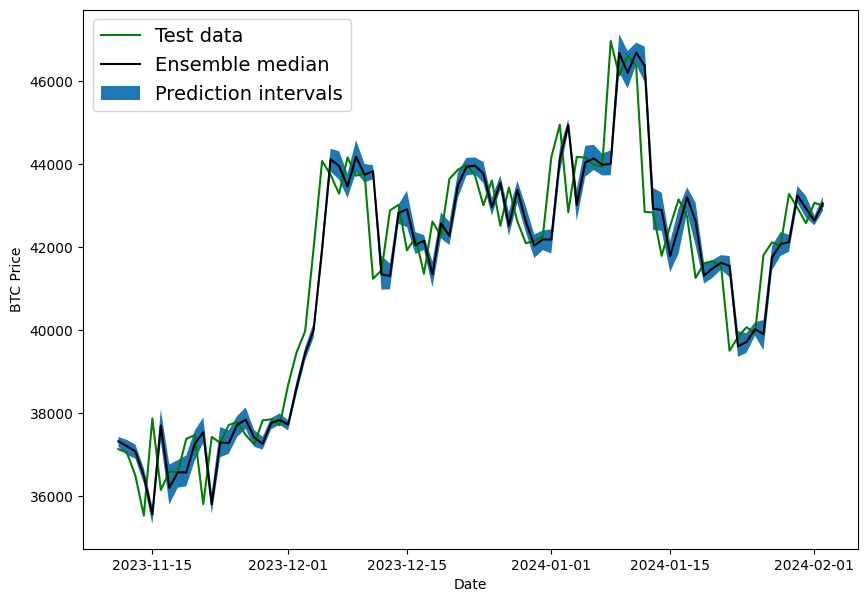

In [252]:
# Get the median/mean of the ensemble predictions
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of the ensemble predictions along the prediction intervals
offset = 600
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble median')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.fill_between(X_test.index[offset:], (lower)[offset:], (upper)[offset:], label='Prediction intervals')
plt.legend(loc='upper left', fontsize=14);

> These prediction intervals are estimates and are created while assuming that the data is normally distributed.

## Model 9: Future Prediction Model

Train a model on the full historical data and make predictions into the future.

In [253]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [254]:
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

len(X_all), len(y_all)

(3419, 3419)

In [255]:
# Turn the features and labels data into tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels and create the training dataset
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch the training data for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [257]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_9_future')

model_9.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.legacy.Adam()
)

model_9.fit(dataset_all, epochs=100, verbose=0)

### Making Predictions into the Future

To make predictions into a future timestep, the model is trained again with the previous timestep predictions until the required timestep has been reached.

In [307]:
# Set the number of timesteps into the predicted future
INTO_FUTURE = 30

In [308]:
def make_future_forecast(values, model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE) -> list:
    """Make future forecasts: `into_future` after `values` end.

    Args:
        values: A list of historical data.
        model: A model trained on the historical data.
        into_future: Window into the future to predict.
        window_size: Window size the model was trained on.

    Returns:
        A list of future forecasts.
    """
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]

    # Make INTO_FUTURE number of predictions while altering the predicted data at each step
    for _ in range(INTO_FUTURE):
        # Predict on the last window then append it to make forecasts into the future,
        # the model will start making forecasts based on the forecasts it has already made
        future_pred = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)
        print(f'Predicting on: {last_window}\nPrediction: {tf.squeeze(future_pred)}\n')

        # Append predictions to the future forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update the last window on the new prediction
        # and get WINDOW_SIZE most recent predictions
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

        # Retrain the model with the predicted values
        model.fit(tf.expand_dims(last_window, axis=0), future_pred, epochs=100, verbose=0)

    return future_forecast

In [309]:
future_forecast = make_future_forecast(values=y_all, model=model_9)

Predicting on: [42120.054688 42035.59375  43288.246094 42952.609375 42582.605469
 43075.773438 42998.191406]
Prediction: 42232.91015625

Predicting on: [42035.59375    43288.246094   42952.609375   42582.605469
 43075.773438   42998.191406   42232.91015625]
Prediction: 42387.62890625

Predicting on: [43288.246094   42952.609375   42582.605469   43075.773438
 42998.191406   42232.91015625 42387.62890625]
Prediction: 42165.63671875

Predicting on: [42952.609375   42582.605469   43075.773438   42998.191406
 42232.91015625 42387.62890625 42165.63671875]
Prediction: 42096.68359375

Predicting on: [42582.605469   43075.773438   42998.191406   42232.91015625
 42387.62890625 42165.63671875 42096.68359375]
Prediction: 42444.7265625

Predicting on: [43075.773438   42998.191406   42232.91015625 42387.62890625
 42165.63671875 42096.68359375 42444.7265625 ]
Prediction: 42381.140625

Predicting on: [42998.191406   42232.91015625 42387.62890625 42165.63671875
 42096.68359375 42444.7265625  42381.1406

In [310]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2024-01-29,43288.246094,6.25,42035.593750,42120.054688,41816.871094,39933.808594,40077.074219,39845.550781,39507.367188
2024-01-30,42952.609375,6.25,43288.246094,42035.593750,42120.054688,41816.871094,39933.808594,40077.074219,39845.550781
2024-01-31,42582.605469,6.25,42952.609375,43288.246094,42035.593750,42120.054688,41816.871094,39933.808594,40077.074219
2024-02-01,43075.773438,6.25,42582.605469,42952.609375,43288.246094,42035.593750,42120.054688,41816.871094,39933.808594
2024-02-02,42998.191406,6.25,43075.773438,42582.605469,42952.609375,43288.246094,42035.593750,42120.054688,41816.871094


### Plot the Future Forecasts

In [311]:
future_forecast

[42232.91,
 42387.63,
 42165.637,
 42096.684,
 42444.727,
 42381.14,
 42341.85,
 42646.152,
 42530.78,
 42588.426,
 42709.156,
 42681.38,
 42668.082,
 42971.547,
 43058.746,
 42940.277,
 42906.766,
 42801.652,
 43061.78,
 43225.695,
 43251.195,
 43349.184,
 43584.477,
 43577.297,
 43560.637,
 43194.56,
 43167.17,
 43058.6,
 42866.035,
 42811.17]

In [312]:
def get_future_dates(start_date, into_future, offset=1):
    """Returns an array of datetime values ranging form (start_date) to (start_date + into_future).
    """
    start_date = start_date + np.timedelta64(offset, 'D')    # 'D' stands for day
    end_date = start_date + np.timedelta64(into_future, 'D')

    return np.arange(start_date, end_date, dtype='datetime64[D]')

In [313]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2024-02-02 00:00:00')

In [314]:
next_timesteps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)
next_timesteps

array(['2024-02-03', '2024-02-04', '2024-02-05', '2024-02-06',
       '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-10',
       '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14',
       '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-18',
       '2024-02-19', '2024-02-20', '2024-02-21', '2024-02-22',
       '2024-02-23', '2024-02-24', '2024-02-25', '2024-02-26',
       '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01',
       '2024-03-02', '2024-03-03'], dtype='datetime64[D]')

In [316]:
next_timesteps = np.insert(next_timesteps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])

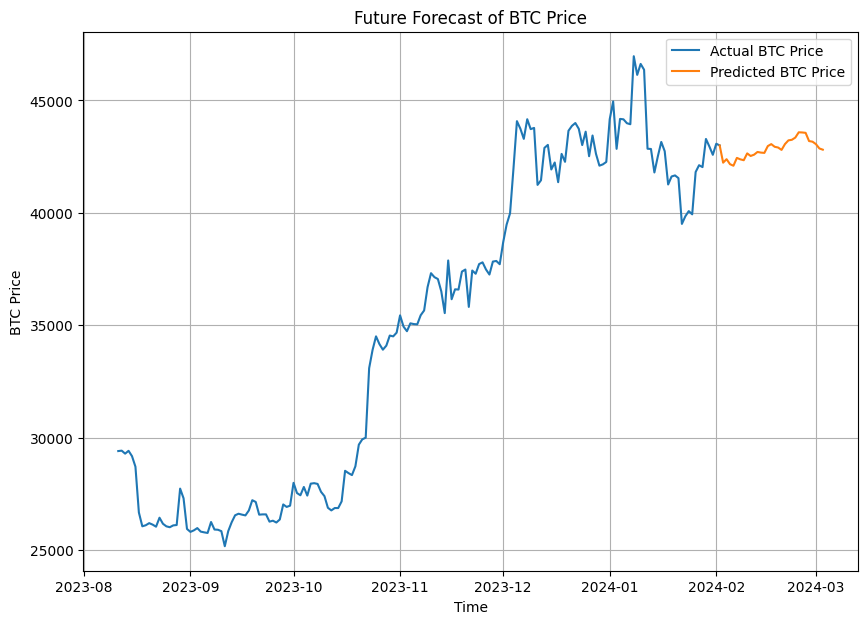

In [317]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, prices, start=3250, format='-', label='Actual BTC Price')
plot_time_series(next_timesteps, future_forecast, format='-', label='Predicted BTC Price')
plt.ylabel('BTC Price')
plt.title('Future Forecast of BTC Price');

## Model 10: Dense Model (The Turkey Problem)

This model is used to emphasise how forecasting is unreliable.

In [322]:
# Introduce a turkey problem into the BTC historical data:
# price of BTC falls by a factor of 100 in a day
prices_turkey = prices.copy()
prices_turkey[-1] /= 100

prices_turkey[-10:]

array([40077.074219  , 39933.808594  , 41816.871094  , 42120.054688  ,
       42035.59375   , 43288.246094  , 42952.609375  , 42582.605469  ,
       43075.773438  ,   429.98191406])

In [324]:
timesteps_turkey = np.array(bitcoin_prices.index)
timesteps_turkey[-10:]

array(['2024-01-24T00:00:00.000000000', '2024-01-25T00:00:00.000000000',
       '2024-01-26T00:00:00.000000000', '2024-01-27T00:00:00.000000000',
       '2024-01-28T00:00:00.000000000', '2024-01-29T00:00:00.000000000',
       '2024-01-30T00:00:00.000000000', '2024-01-31T00:00:00.000000000',
       '2024-02-01T00:00:00.000000000', '2024-02-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

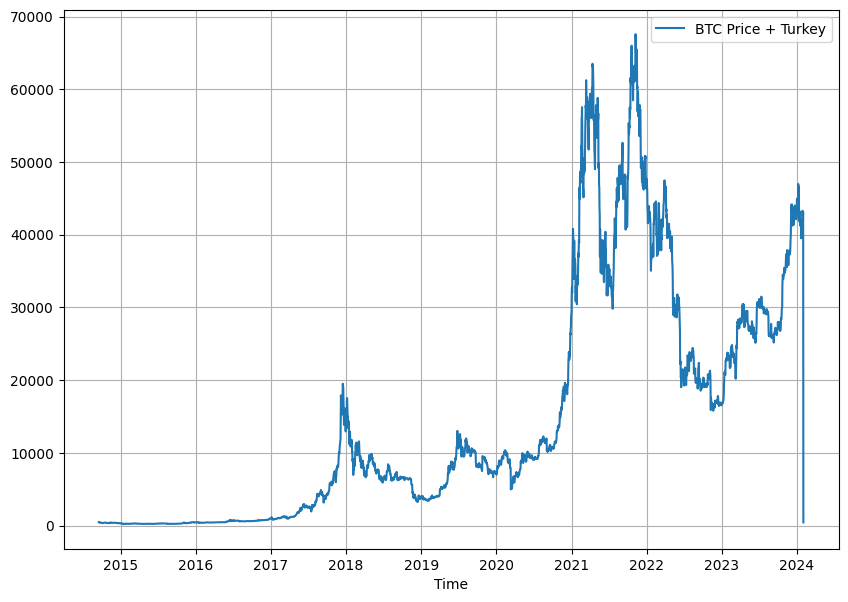

In [325]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=timesteps_turkey, values=prices_turkey, format='-', label='BTC Price + Turkey')

In [326]:
HORIZON = 1
WINDOW_SIZE = 7

In [329]:
full_windows, full_labels = make_windows(
    x=np.array(prices_turkey),
    window_size=WINDOW_SIZE,
    horizon=HORIZON
)

In [330]:
X_train, X_test, y_train, y_test = make_train_test_split(full_windows, full_labels)

In [331]:
tf.random.set_seed(42)

turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = 'model_10_turkey'

turkey_model.compile(loss='mae', optimizer='Adam')

turkey_model.fit(
    X_train, y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[
        create_model_checkpoint(model_name=turkey_model.name)
    ]
)

In [332]:
turkey_model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 580us/step - loss: 867.4373


867.437255859375

In [333]:
turkey_model = tf.keras.models.load_model('mp3_experiments/model_10_turkey/')
turkey_model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 569us/step - loss: 568.7750


568.7749633789062

In [334]:
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

22/22 [==============================] - 0s 548us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41441.61 , 41039.324, 42147.66 , 42771.34 , 43815.242, 44407.566,
       44549.953, 46469.117, 47147.016, 47455.2  ], dtype=float32)>

In [335]:
turkey_results = evaluate_preds(y_true=y_test, y_pred=turkey_preds)
turkey_results

{'mae': 9020.161,
 'mse': 131253550.0,
 'rmse': 10996.405,
 'mape': 43.183403,
 'mase': 15.892516}

In [336]:
model_1_results

{'mae': 507.1901,
 'mse': 603887.0,
 'rmse': 777.1017,
 'mape': 1.8372449,
 'mase': 1.0038447}

In [341]:
offset

600

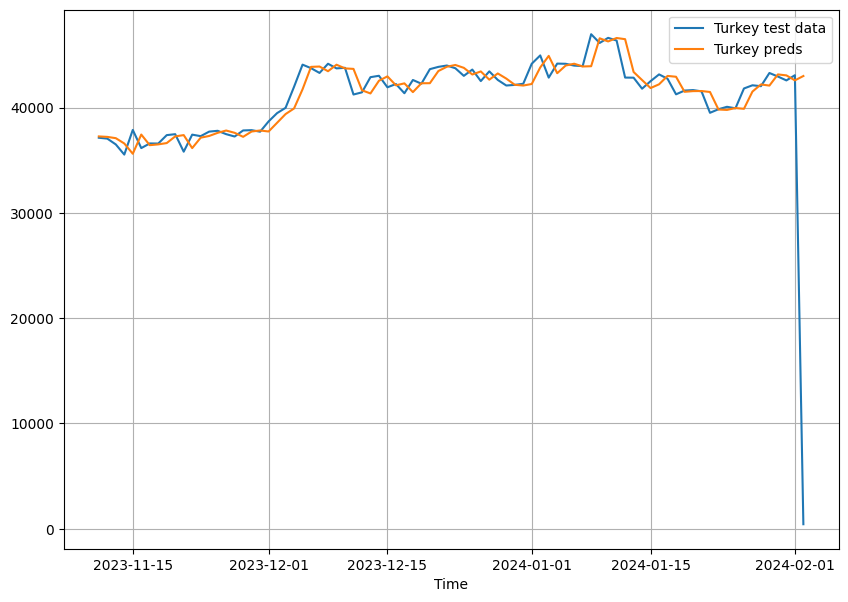

In [342]:
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=timesteps_turkey[-len(X_test):],
    values=prices_turkey[-len(y_test):],
    format='-',
    label='Turkey test data',
    start=offset
)
plot_time_series(
    timesteps=timesteps_turkey[-len(X_test):],
    values=turkey_preds,
    format='-',
    label='Turkey preds',
    start=offset
)

## Compare the Modelling Experiments

In [345]:
model_results = pd.DataFrame({
    'naive_model': naive_results,
    'model_1_dense_w7_h1': model_1_results,
    'model_2_dense_w30_h1': model_2_results,
    'model_3_dense_w30_h7': model_3_results,
    'model_4_conv1d': model_4_results,
    'model_5_lstm': model_5_results,
    'model_6_multivariate': model_6_results,
    'model_7_nbeats': model_7_results,
    'model_8_ensemble': ensemble_results,
    'model_10_turkey': turkey_results
}).T

model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,505.396729,6.016744e+05,775.676758,1.823844,1.001267
model_1_dense_w7_h1,507.190094,6.038870e+05,777.101685,1.837245,1.003845
model_2_dense_w30_h1,531.668396,6.333545e+05,795.835754,1.929510,1.056140
model_3_dense_w30_h7,1082.687988,2.699470e+06,1251.279907,3.979657,2.147552
model_4_conv1d,509.807281,6.073309e+05,779.314392,1.848879,1.009025
model_5_lstm,528.108582,6.395738e+05,799.733521,1.918025,1.045247
model_6_multivariate,505.076263,6.015154e+05,775.574280,1.827839,0.999661
model_7_nbeats,503.652588,5.987546e+05,773.792358,1.821132,0.996843
model_8_ensemble,504.960083,6.008112e+05,775.120178,1.826293,0.999431
model_10_turkey,9020.161133,1.312536e+08,10996.405273,43.183403,15.892516


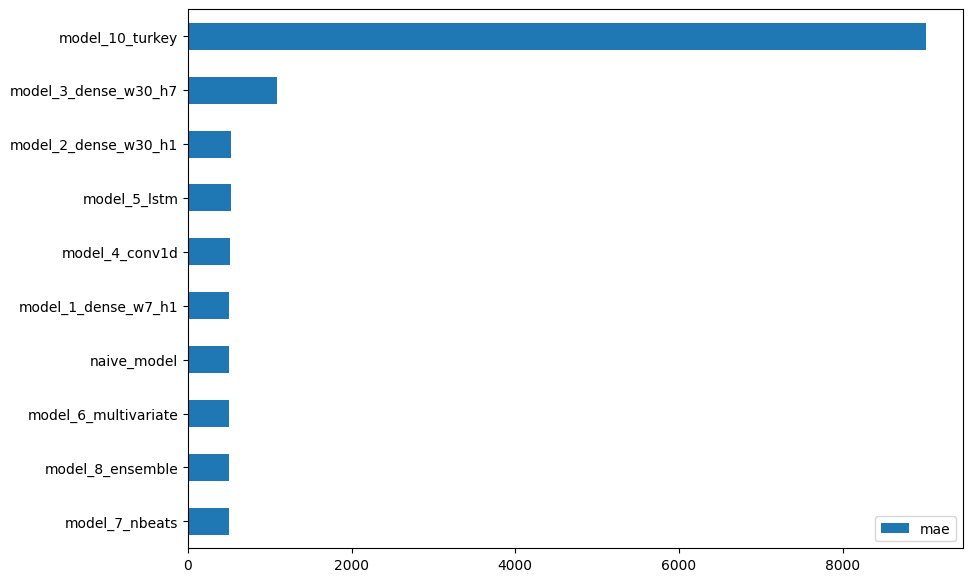

In [351]:
model_results[['mae']].sort_values(by='mae').plot(figsize=(10, 7), kind='barh');